<a href="https://colab.research.google.com/github/YasudaKaito/pytorch_book_akaishi/blob/main/ch06_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6.6 交差エントロピー関数
- 2値分類の場合
  - 「分類結果が1になる確率」が $f(u)$ なら
  - 「分類結果が0になる確率」は $1-f(u)$
- 「モデル確信度」（予測結果が正解の確率）は以下のようになる
    - 正解 $yt = 1$ の場合、 $f(u)$
    - 正解 $yt = 0$ の場合、 $1-f(u)$
- すべてのデータに対する確信度（予測結果が正解の確率）をかけ合わせた結果を最大化するパラメータが一番尤もらしいので採用する → 最尤推定
- 計算しやすいよう(積を和に変換)、対数を取る
- 損失関数は「最小化」するものなので、マイナスをかける
- 更にデータ件数で割って平均を取る


$$
-\frac{1}{n}\sum^n_i\{yt_i \cdot log(f(u_i)) + (1-yt_i) \cdot log(1-f(u_i))\}
$$


# 6.7 データ準備

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

In [2]:
x_org, y_org = iris.data, iris.target
print(x_org.shape)
print(y_org.shape)

(150, 4)
(150,)


In [3]:
# クラス0,1のみ Setosa, Versicolorのみ
# 列 sepal_length, sepal_widthのみ
x_data = iris.data[:100, :2]
y_data = iris.target[:100]
print(x_data)
print(y_data)

[[5.1 3.5]
 [4.9 3. ]
 [4.7 3.2]
 [4.6 3.1]
 [5.  3.6]
 [5.4 3.9]
 [4.6 3.4]
 [5.  3.4]
 [4.4 2.9]
 [4.9 3.1]
 [5.4 3.7]
 [4.8 3.4]
 [4.8 3. ]
 [4.3 3. ]
 [5.8 4. ]
 [5.7 4.4]
 [5.4 3.9]
 [5.1 3.5]
 [5.7 3.8]
 [5.1 3.8]
 [5.4 3.4]
 [5.1 3.7]
 [4.6 3.6]
 [5.1 3.3]
 [4.8 3.4]
 [5.  3. ]
 [5.  3.4]
 [5.2 3.5]
 [5.2 3.4]
 [4.7 3.2]
 [4.8 3.1]
 [5.4 3.4]
 [5.2 4.1]
 [5.5 4.2]
 [4.9 3.1]
 [5.  3.2]
 [5.5 3.5]
 [4.9 3.6]
 [4.4 3. ]
 [5.1 3.4]
 [5.  3.5]
 [4.5 2.3]
 [4.4 3.2]
 [5.  3.5]
 [5.1 3.8]
 [4.8 3. ]
 [5.1 3.8]
 [4.6 3.2]
 [5.3 3.7]
 [5.  3.3]
 [7.  3.2]
 [6.4 3.2]
 [6.9 3.1]
 [5.5 2.3]
 [6.5 2.8]
 [5.7 2.8]
 [6.3 3.3]
 [4.9 2.4]
 [6.6 2.9]
 [5.2 2.7]
 [5.  2. ]
 [5.9 3. ]
 [6.  2.2]
 [6.1 2.9]
 [5.6 2.9]
 [6.7 3.1]
 [5.6 3. ]
 [5.8 2.7]
 [6.2 2.2]
 [5.6 2.5]
 [5.9 3.2]
 [6.1 2.8]
 [6.3 2.5]
 [6.1 2.8]
 [6.4 2.9]
 [6.6 3. ]
 [6.8 2.8]
 [6.7 3. ]
 [6.  2.9]
 [5.7 2.6]
 [5.5 2.4]
 [5.5 2.4]
 [5.8 2.7]
 [6.  2.7]
 [5.4 3. ]
 [6.  3.4]
 [6.7 3.1]
 [6.3 2.3]
 [5.6 3. ]
 [5.5 2.5]
 [5.5 2.6]

In [4]:
print(x_data.shape)
print(y_data.shape)

(100, 2)
(100,)


In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=70, test_size=30, random_state=123)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(70, 2)
(30, 2)
(70,)
(30,)


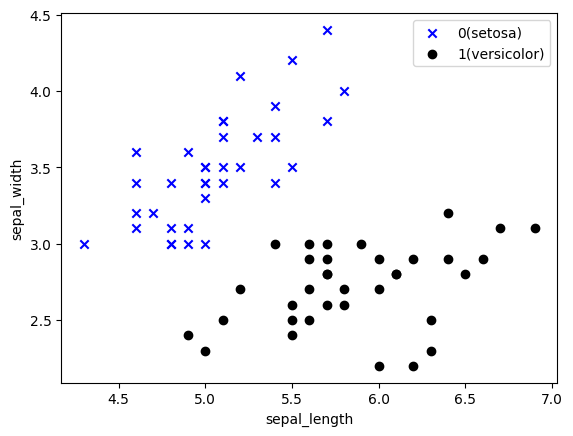

In [6]:
import matplotlib.pyplot as plt

# 散布図
x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
plt.scatter(x_t0[:, 0], x_t0[:, 1], marker="x", c="b", label="0(setosa)")
plt.scatter(x_t1[:, 0], x_t1[:, 1], marker="o", c="k", label="1(versicolor)")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.legend()
plt.show()

# 6.8 モデル定義

In [7]:
n_input = x_train.shape[1]
n_output = 1

In [8]:
import torch
import torch.nn as nn

# 入力2次元, 出力1次元のロジスティック回帰
class Net(nn.Module):
    def __init__(self, n_input, n_output) -> None:
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
        self.sigmoid = nn.Sigmoid()
        # 初期値は1
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.sigmoid(x1)
        return x2

In [9]:
# モデルの概要表示
net = Net(n_input, n_output)
print(net)

Net(
  (l1): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [10]:
inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).float()
# 正解データはn行1列にする
labels1 = labels.view((-1, 1))

# 検証データ
inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).float()
labels1_test = labels_test.view((-1, 1))

In [12]:
import torch.optim as optim
import numpy as np

# 初期化処理
lr = 0.01
net = Net(n_input, n_output)
# 交差エントロピー
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=lr)
num_epochs = 10000
# 記録用
history = np.zeros((0, 5))

In [13]:
for epoch in range(num_epochs):
    # --- 訓練フェーズ ---
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels1)
    loss.backward()
    optimizer.step()

    # 記録用
    train_loss = loss.item()
    # 予測データ(0 or 1)計算
    predicted = torch.where(outputs < 0.5, 0, 1)
    # 精度
    train_acc = (predicted == labels1).sum() / len(y_train)

    # --- 予測フェーズ ---
    outputs_test = net(inputs_test)
    loss_test = criterion(outputs_test, labels1_test)

    # 記録用
    val_loss = loss_test.item()
    predicted_test = torch.where(outputs_test < 0.5, 0, 1)
    val_acc = (predicted_test == labels1_test).sum() / len(y_test)

    if (epoch % 10 == 0):
        print(f"Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f} val_acc: {val_acc:.5f}")
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 4.77289 acc: 0.50000 val_loss: 4.49384 val_acc: 0.50000
Epoch [10/10000], loss: 3.80546 acc: 0.50000 val_loss: 3.56537 val_acc: 0.50000
Epoch [20/10000], loss: 2.84329 acc: 0.50000 val_loss: 2.64328 val_acc: 0.50000
Epoch [30/10000], loss: 1.91613 acc: 0.50000 val_loss: 1.76244 val_acc: 0.50000
Epoch [40/10000], loss: 1.17137 acc: 0.50000 val_loss: 1.08537 val_acc: 0.50000
Epoch [50/10000], loss: 0.84140 acc: 0.50000 val_loss: 0.81872 val_acc: 0.50000
Epoch [60/10000], loss: 0.77087 acc: 0.50000 val_loss: 0.77093 val_acc: 0.50000
Epoch [70/10000], loss: 0.75450 acc: 0.34286 val_loss: 0.76105 val_acc: 0.33333
Epoch [80/10000], loss: 0.74542 acc: 0.25714 val_loss: 0.75447 val_acc: 0.20000
Epoch [90/10000], loss: 0.73734 acc: 0.24286 val_loss: 0.74778 val_acc: 0.16667
Epoch [100/10000], loss: 0.72949 acc: 0.24286 val_loss: 0.74098 val_acc: 0.13333
Epoch [110/10000], loss: 0.72180 acc: 0.27143 val_loss: 0.73419 val_acc: 0.16667
Epoch [120/10000], loss: 0.71423 acc: 0

In [14]:
# パラメータの取得
bias = net.l1.bias.data.numpy()
weight = net.l1.weight.data.numpy()
print(f'BIAS = {bias}, WEIGHT = {weight}')

BIAS = [0.3386128], WEIGHT = [[ 2.9700322 -5.300015 ]]


In [15]:
# 決定境界描画用 x1の値から x2の値を計算する
# 決定境界は w1x1 + w2x2 + b = 0 という直線の方程式となる
# この方程式にデータ点の座標を代入してその正負で分類ができる
# この方程式をx2について解いて以下を得る
def decision(x):
    return(-(bias + weight[0,0] * x)/ weight[0,1])

# 散布図のx1の最小値と最大値（グラフの端点を取得）
xl = np.array([x_test[:,0].min(), x_test[:,0].max()])
yl = decision(xl)

# 結果確認
print(f'xl = {xl}  yl = {yl}')

xl = [4.4 7. ]  yl = [2.52956918 3.986562  ]


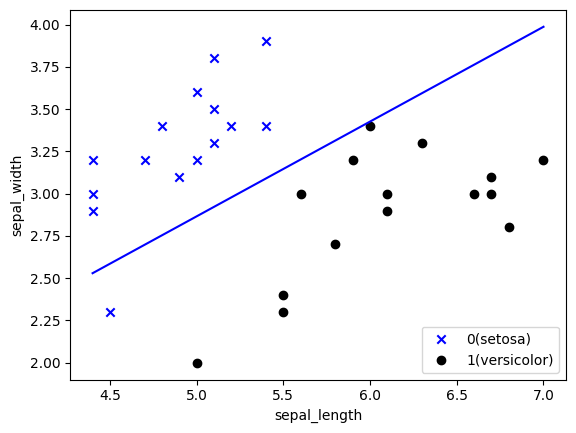

In [17]:
# テストデータの散布図に決定境界を描画
x_t0 = x_test[y_test==0]
x_t1 = x_test[y_test==1]

plt.scatter(x_t0[:, 0], x_t0[:, 1], marker="x", c="b", label="0(setosa)")
plt.scatter(x_t1[:, 0], x_t1[:, 1], marker="o", c="k", label="1(versicolor)")
plt.plot(xl, yl, c="b")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.legend()
plt.show()